# Importing libraries

In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import torch # Like a numpy but we could work with GPU by pytorch library
import torch.nn as nn # Neural Network Implimented with pytorch
import torchvision # A library for work with pretrained model and datasets
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import glob
import os
%matplotlib inline



In [2]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

image_size = (224, 224) #resizing image size
image_row_size = image_size[0] * image_size[1]


# Creating dataset class

In [3]:
#Creating class for getting dataset
class CatDogDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        return im.view(-1), classCategory

In [4]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
                                transforms.Resize(image_size), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])

In [5]:
#Calling the dataset function
path    = '/home/aims/Documents/Machine Learning materials/Machine learning algorithms/Cat_Dog_classifier/train'
dataset = CatDogDataset(path, transform=transform)
path_test    = '/home/aims/Documents/Machine Learning materials/Machine learning algorithms/Cat_Dog_classifier/test'
dataset = CatDogDataset(path, transform=transform)
data_test=CatDogDataset(path_test, transform=transform)

In [6]:
#Plotting images
def imshow(source):
    plt.figure(figsize=(10,10))
    imt = (source.view(-1, image_size[0], image_size[0]))
    imt = imt.numpy().transpose([1,2,0])
    imt = (std * imt + mean).clip(0,1)
    plt.subplot(1,2,2)
    plt.imshow(imt)

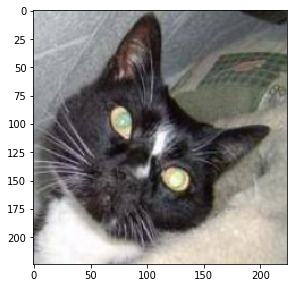

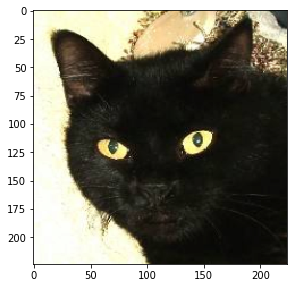

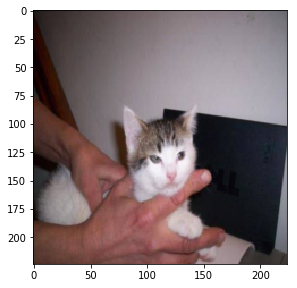

In [7]:
imshow(dataset[0][0])
imshow(dataset[2][0])
imshow(dataset[6000][0])

In [8]:
#Calling dataloader function
shuffle     = True
batch_size  = 20
num_workers = 0
train_loader  = DataLoader(dataset=dataset, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers)


test_loader  = DataLoader(dataset=data_test, 
                         shuffle=False, 
                         batch_size=batch_size, 
                         num_workers=num_workers)



In [9]:
#Defining parameters
input_size  = 224*224*3 # the number of featutes /pixels values in an image
output_size = 2


# Create the model classes

In [16]:
#creating full connected neural network class
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size): #n_hidden is numbers neurons/units
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x): #x -batch of images 
        x = x.view(-1, self.input_size)#
        return self.network(x)


#Simple convolutional neural network   
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*53*53, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*53*53)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
   
    
    
    
    
    
#Creating convolutional neural network with four layers
    
class ConvNet(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(ConvNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, 2*n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(2*n_feature, 2**2*n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(2**2*n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*10*10, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*10*10)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 224*224).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # permute pixels
        data = data.view(-1, 224*224)
        data = data[:, perm]
        data = data.view(-1, 3, 224, 224)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 224*224).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # permute pixels
        data = data.view(-1, 224*224)
        data = data[:, perm]
        data = data.view(-1, 3, 224, 224)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network


In [13]:
n_hidden = 8 # number of hidden units
 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)


Number of parameters: 1204322
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.687490
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.682107
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.711293
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.695960
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.812304
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.736178
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.800350
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.681697
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.689525
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.688458
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.748599
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.765538

Test set: Average loss: 0.6474, Accuracy: 1547/2500 (62%)



# Train a Simple ConvNet with the same number of parameters

In [14]:
# Training settings 
n_features = 8 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 1125968
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.695157
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.659059
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.759429
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.734998
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.715049
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.577977
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.771715
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.495700
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.770716
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.607566
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.597299
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.506078

Test set: Average loss: 0.6116, Accuracy: 1654/2500 (66%)



# Train a Multilayer ConvNet with the same number of parameters

In [17]:
# Training settings 
n_features = 8 # number of feature maps

model_cnn = ConvNet(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 63216
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.692459
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.687183
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.700208
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.686449
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.669235
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.649314
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.687583
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.749230
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.664865
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.673481
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.591595
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.596611

Test set: Average loss: 0.6751, Accuracy: 1475/2500 (59%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

    - Use of convolution: Locality and stationarity in images
    - Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

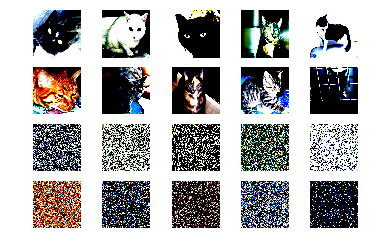

In [24]:
perm = torch.randperm(224*224)
plt.figure()
for i in range(10):
    image = train_loader.dataset.__getitem__(i)[0].view(-1, 3, 224, 224)
    # permute pixels
    image_perm = image.view(-1, 224*224).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 3, 224, 224)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0))
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy().transpose(1,2,0))
    plt.axis('off')